# Visión Computacional Basada en Redes Neuronales Artificiales
## Grupo 3 - Trabajo Práctico Especial

Integrantes del grupo:

* Joaquín Sebastián Tschopp
* Santiago Bezchinsky





## 0. Importaciones de librerías

In [1]:
# Librerías de PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.transforms.v2 as T

# Extras
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
import os
from os import path
from datetime import datetime
from enum import Enum
from dataclasses import dataclass
import textwrap

import torch
import torch.nn as nn

import torchvision
from torchview import draw_graph

# Configuración del ambiente para Colab (Esto no lo toque)

# montamos la unidad de Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

# carpeta donde van a guardar los datos
from os import makedirs
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/Computer Vision/Grupo 3'
makedirs(datasets_folder, exist_ok=True)

# NO TOCAR EL CÓDIGO DE ACÁ ABAJO, ES PARA BAJAR DATOS NUEVOS!
new_datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/Computer Vision/'
makedirs(new_datasets_folder, exist_ok=True)
!rm /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/cifar10.1_v4_data.npy*
!rm /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/cifar10.1_v4_labels.npy*
!wget --no-check-certificate -P /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/ https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_data.npy
!wget --no-check-certificate -P /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/ https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_labels.npy
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/

# Carga de Datos en Local!!! (:rocket)

In [2]:
# Configuración de carpetas para uso local
from os import makedirs, path
import urllib.request
import os

# Carpeta local donde van a guardar los datos
datasets_folder = 'datasets/Grupo_3'
makedirs(datasets_folder, exist_ok=True)

# Carpeta para datos nuevos (CIFAR10.1)
new_datasets_folder = 'datasets/Grupo_3'
makedirs(new_datasets_folder, exist_ok=True)

# Rutas de los archivos
data_file = path.join(new_datasets_folder, 'cifar10.1_v4_data.npy')
labels_file = path.join(new_datasets_folder, 'cifar10.1_v4_labels.npy')

# URLs de descarga
data_url = 'https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_data.npy'
labels_url = 'https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_labels.npy'

# Descargar archivos si no existen
def download_file(url, filename):
    if not path.exists(filename):
        print(f"Descargando {filename}...")
        urllib.request.urlretrieve(url, filename)
        print(f"✓ {filename} descargado")
    else:
        print(f"✓ {filename} ya existe")

download_file(data_url, data_file)
download_file(labels_url, labels_file)

# Listar archivos en la carpeta
print(f"\nArchivos en {new_datasets_folder}:")
for item in os.listdir(new_datasets_folder):
    item_path = path.join(new_datasets_folder, item)
    if path.isfile(item_path):
        size_mb = path.getsize(item_path) / (1024 * 1024)
        print(f"  - {item} ({size_mb:.2f} MB)")
    else:
        print(f"  - {item}/ (directorio)")

✓ datasets/Grupo_3/cifar10.1_v4_data.npy ya existe
✓ datasets/Grupo_3/cifar10.1_v4_labels.npy ya existe

Archivos en datasets/Grupo_3:
  - cifar-10-batches-py/ (directorio)
  - cifar10.1_v4_data.npy (5.92 MB)
  - cifar10.1_v4_labels.npy (0.01 MB)
  - cifar-10-python.tar.gz (162.60 MB)


# 1. Carga y preprocesamiento de los datos

Cargamos los datos de entrenamiento, calculamos media y desvío para normalizar

In [3]:
cifar10_training = datasets.CIFAR10(datasets_folder, train=True, download=True)
cifar10_training_data = cifar10_training.data

# Calcular media y desvio por canal
mean = np.mean(cifar10_training_data, axis=(0,1,2)) / 255
std = np.std(cifar10_training_data, axis=(0,1,2)) / 255

print(mean, std)

[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [4]:
list_of_training_transformations = [transforms.ToTensor(), transforms.Normalize(mean, std)]
list_of_test_transformations = [transforms.ToTensor(), transforms.Normalize(mean, std)]

# generamos las transformaciones que corresponden
training_transformations = transforms.Compose(list_of_training_transformations)
test_transformations = transforms.Compose(list_of_test_transformations)

# descargamos los datos de entrenamiento (o los levantamos, si ya están ahí)
cifar10_training = datasets.CIFAR10(datasets_folder, train=True, download=True, transform=training_transformations)
# hacemos lo mismo con los de test (que los vamos a usar de datos de validación)
cifar10_validation = datasets.CIFAR10(datasets_folder, train=False, download=True, transform=test_transformations)

# 2. Arquitectura del Modelo y Pipeline de Entrenamiento

Esto es una **arquitectura orientada a objetos** con la clase `TrainingPipeline` que encapsula todo el flujo de trabajo:

## Resumen del Pipeline

### Estructura de **programación orientada a objetos** con la clase `TrainingPipeline`.

---

### Flujo de Trabajo Simplificado

```python
# 1. Configurar hiperparámetros
config = {'lr': 0.001, 'epochs': 50, 'batch_size': 64, 'patience': 10}

# 2. Crear modelo y pipeline
model = BaseModel()
pipeline = TrainingPipeline(model, config)

# 3. Entrenar (automático: early stopping, checkpoints)
pipeline.train(train_loader, val_loader)

# 4. Visualizar curvas
pipeline.plot_training_curves()

# 5. Evaluar en test
results = pipeline.evaluate(test_loader, "CIFAR-10.1")

# 6. Visualizar resultados
pipeline.plot_confusion_matrix(results['predictions'], results['labels'], class_names)
```

---

In [5]:
# ==============================================================================
# ARQUITECTURA DEL MODELO 1.0
# ==============================================================================

class BaseModel(nn.Module):
    """
    Modelo base con arquitectura fully connected de 2 capas.
    Para clasificación de imágenes en 10 clases usando datos de CIFAR10
    """
    
    def __init__(self):
        super(BaseModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 10)
        )
        self.final_activation = nn.Softmax(dim=1)
    
    def forward(self, inputs):
        """Forward pass"""
        return self.model(inputs)
    
    def predict(self, inputs):
        """Predicción con softmax"""
        return self.final_activation(self.model(inputs))

In [6]:
# ==============================================================================
# ARQUITECTURAS CNN ALTERNATIVAS PARA CIFAR-10
# ==============================================================================

# ==============================================================================
# OPCIÓN 1: CNN Simple
# ==============================================================================
class SimpleCNN(nn.Module):
    """
    CNN básica con 3 bloques convolucionales
    
    Arquitectura:
    - 3 bloques Conv -> ReLU -> MaxPool
    - 2 capas fully connected
    - Dropout para regularización
    
    """
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Bloque 1: 3 -> 32 canales
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Bloque 2: 32 -> 64 canales
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Bloque 3: 64 -> 128 canales
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # Regularización
        self.dropout = nn.Dropout(0.5)
        
        # Activación final
        self.final_activation = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Bloque 1
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Bloque 2
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Bloque 3
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        # Flatten
        x = x.view(-1, 128 * 4 * 4)
        
        # FC con dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def predict(self, x):
        return self.final_activation(self.forward(x))


# ==============================================================================
# OPCIÓN 2: CNN Mejorada con Batch Normalization
# ==============================================================================
class ImprovedCNN(nn.Module):
    """
    CNN con Batch Normalization y arquitectura más profunda
    
    Arquitectura:
    - 4 bloques Conv -> BatchNorm -> ReLU -> MaxPool
    - 2 capas fully connected con BatchNorm
    - Dropout para regularización
    
    Parámetros: ~340K
    Accuracy esperado: ~75-80%
    
    """
    
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        
        # Bloque 1: 3 -> 64 canales
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Bloque 2: 64 -> 128 canales
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Bloque 3: 128 -> 256 canales
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Bloque 4: 256 -> 256 canales
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Bloque 5: 256 -> 512 canales
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected con BatchNorm
        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        
        # Regularización
        self.dropout = nn.Dropout(0.5)
        
        # Activación final
        self.final_activation = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Bloque 1
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Bloque 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(x)
        
        # Bloque 3
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Bloque 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout(x)
        
        # Bloque 5
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)
        x = self.dropout(x)
        
        # Flatten
        x = x.view(-1, 512 * 4 * 4)
        
        # FC con BatchNorm y Dropout
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def predict(self, x):
        return self.final_activation(self.forward(x))


# ==============================================================================
# OPCIÓN 3: ResNet-like con Skip Connections
# ==============================================================================
class ResidualBlock(nn.Module):
    """Bloque residual básico con skip connection"""
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection con ajuste de dimensión
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Skip connection
        out += self.shortcut(identity)
        out = F.relu(out)
        
        return out


class ResNetCIFAR(nn.Module):
    """
    ResNet adaptado para CIFAR-10 con skip connections
    
    Arquitectura:
    - Capa inicial convolucional
    - 3 grupos de bloques residuales
    - Global Average Pooling
    - Fully connected final

    """
    
    def __init__(self, num_blocks=[2, 2, 2]):
        super(ResNetCIFAR, self).__init__()
        
        # Capa inicial
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Grupos de bloques residuales
        self.layer1 = self._make_layer(64, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks[2], stride=2)
        
        # Clasificador
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 10)
        
        # Activación final
        self.final_activation = nn.Softmax(dim=1)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        
        # Primer bloque puede cambiar dimensiones
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        
        # Bloques subsecuentes mantienen dimensiones
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Capa inicial
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Bloques residuales
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global Average Pooling
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Clasificador
        x = self.fc(x)
        
        return x
    
    def predict(self, x):
        return self.final_activation(self.forward(x))

# ==============================================================================
# Optimizador: declaracion de optimizador como ENUM
# ==============================================================================
#https://docs.pytorch.org/docs/stable/optim.html

class Optimizer(Enum):
    SGD = 'SGD'
    ADAM = 'Adam'
    ADAMW = 'AdamW'
    RMSPROP = 'RMSProp'




# ==============================================================================
# FUNCIÓN AUXILIAR: Comparar arquitecturas
# ==============================================================================
def compare_models():
    """Compara las 4 arquitecturas disponibles"""
    models = {
        'BaseModel (actual)': BaseModel(),
        'SimpleCNN': SimpleCNN(),
        'ImprovedCNN': ImprovedCNN(),
        'ResNetCIFAR': ResNetCIFAR()
    }
    
    print("="*70)
    print("COMPARACIÓN DE ARQUITECTURAS")
    print("="*70)
    
    for name, model in models.items():
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"\n{name}")
        print(f"  Parámetros totales: {total_params:,}")
        print(f"  Parámetros entrenables: {trainable_params:,}")
        
        # Calcular tamaño en MB
        param_size = total_params * 4 / (1024**2)  # 4 bytes por parámetro (float32)
        print(f"  Tamaño estimado: {param_size:.2f} MB")
    
    print("\n" + "="*70)
    print("RECOMENDACIÓN: ImprovedCNN para mejor balance complejidad/rendimiento")
    print("="*70)


print("✓ Arquitecturas CNN cargadas exitosamente")
print("\nPara comparar modelos ejecuta: compare_models()")

✓ Arquitecturas CNN cargadas exitosamente

Para comparar modelos ejecuta: compare_models()


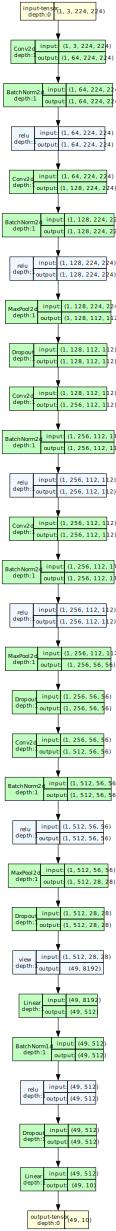

In [7]:
import torchvision
from torchview import draw_graph

model_graph = draw_graph(ImprovedCNN(), input_size=(1,3,224,224), expand_nested=True)
model_graph.visual_graph

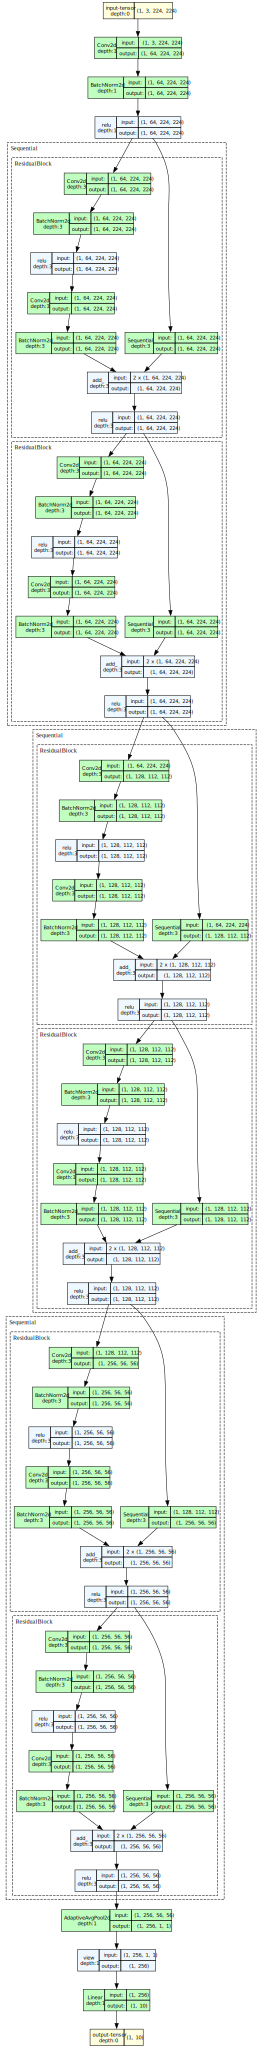

In [8]:
model_graph = draw_graph(ResNetCIFAR(), input_size=(1,3,224,224), expand_nested=True)
model_graph.visual_graph

In [9]:
# ==============================================================================
# COMPARACIÓN DE MODELOS
# ==============================================================================

compare_models()

COMPARACIÓN DE ARQUITECTURAS

BaseModel (actual)
  Parámetros totales: 1,578,506
  Parámetros entrenables: 1,578,506
  Tamaño estimado: 6.02 MB

SimpleCNN
  Parámetros totales: 620,362
  Parámetros entrenables: 620,362
  Tamaño estimado: 2.37 MB

ImprovedCNN
  Parámetros totales: 6,344,458
  Parámetros entrenables: 6,344,458
  Tamaño estimado: 24.20 MB

ResNetCIFAR
  Parámetros totales: 2,777,674
  Parámetros entrenables: 2,777,674
  Tamaño estimado: 10.60 MB

RECOMENDACIÓN: ImprovedCNN para mejor balance complejidad/rendimiento


In [10]:

# ==============================================================================
# PIPELINE DE ENTRENAMIENTO
# ==============================================================================

class TrainingPipeline:
    """
    Pipeline completo de entrenamiento, validación y evaluación
    Incluye:
    - Detección automática de device (CUDA/MPS/CPU)
    - Entrenamiento con early stopping
    - Sistema de checkpoints
    - Evaluación y métricas
    - Visualizaciones profesionales
    """
    
    def __init__(self, model, config):
        """
        Args:
            model: Modelo de PyTorch (nn.Module)
            config: Dict con configuración (lr, epochs, batch_size, patience, etc.)
        """
        # Detección automática de device
        self.device = self._detect_device()
        print(f"Device detectado: {self.device}")
        
        # Modelo y configuración
        self.model = model.to(self.device)
        self.config = config
        
        # Optimizador y loss
        optimizer_type = config.get('optimizer', 'SGD')
        for optimizer in optim.__dict__:
            if optimizer == optimizer_type:
                self.optimizer = optim.__dict__[optimizer](
                    self.model.parameters(), 
                    lr=config['lr'], 
                    # momentum=config.get('momentum', 0.9) # NO for Adam
                )
                break
        
        # Mantenemos solo esta loss por las clases y el label smoothing para pruebas
        self.loss_function = nn.CrossEntropyLoss(
            #https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#:~:text=Default%3A%20%27mean%27-,label_smoothing,-(float%2C
            label_smoothing=0.05 # Por defecto es 0.0
        ).to(self.device)
        
        # Estado del entrenamiento
        self.train_losses = []
        self.val_losses = []
        self.val_metrics = []
        self.best_val_acc = 0.0
        self.best_epoch = 0
        self.current_epoch = 0
        
        # Directorio de checkpoints
        self.checkpoint_dir = config.get('checkpoint_dir', 'models/')
        os.makedirs(self.checkpoint_dir, exist_ok=True)
    
    def _detect_device(self):
        """Detecta el dispositivo disponible"""
        if torch.cuda.is_available():
            return torch.device('cuda')  # NVIDIA GPU
        elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            return torch.device('mps')   # Apple Silicon (M1/M2/M3)
        else:
            return torch.device('cpu')   # CPU fallback
    
    def _train_epoch(self, train_loader):
        """Entrena una época completa"""
        self.model.train()
        running_loss = 0.0
        
        for data, target in train_loader:
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_function(output, target)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * data.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        return epoch_loss
    
    def _validate_epoch(self, val_loader):
        """Valida una época completa"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.loss_function(output, target)
                running_loss += loss.item() * data.size(0)
                
                probs = self.model.final_activation(output)
                preds = probs.argmax(dim=1)
                correct += (preds == target).sum().item()
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct / len(val_loader.dataset)
        return epoch_loss, epoch_acc
    
    def train(self, train_loader, val_loader):
        """
        Entrenamiento completo con early stopping y checkpoints
        
        Args:
            train_loader: DataLoader de entrenamiento
            val_loader: DataLoader de validación
        """
        print("\n" + "="*70)
        print("ENTRENAMIENTO DEL MODELO")
        print("="*70)
        print(f"Épocas: {self.config['epochs']}")
        print(f"Batch size: {self.config['batch_size']}")
        print(f"Learning rate: {self.config['lr']}")
        print(f"Device: {self.device}")
        print(f"Early stopping patience: {self.config['patience']}")
        print("="*70 + "\n")
        
        patience_counter = 0
        
        try:
            for epoch in range(1, self.config['epochs'] + 1):
                self.current_epoch = epoch
                
                # Entrenar
                train_loss = self._train_epoch(train_loader)
                self.train_losses.append(train_loss)
                
                # Validar
                val_loss, val_acc = self._validate_epoch(val_loader)
                self.val_losses.append(val_loss)
                self.val_metrics.append(val_acc)
                
                # Logging
                print(f"Epoch {epoch:02d} | "
                      f"Train Loss: {train_loss:.4f} | "
                      f"Val Loss: {val_loss:.4f} | "
                      f"Val Acc: {val_acc:.2%}", end="")
                
                # Guardar mejor modelo
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_epoch = epoch
                    patience_counter = 0
                    self.save_checkpoint('best_model.pth', is_best=True)
                    print(" ✓ MEJOR", end="")
                else:
                    patience_counter += 1
                
                print()
                
                # Checkpoint periódico
                if epoch % 5 == 0:
                    self.save_checkpoint('last_checkpoint.pth')
                    print(f"  → Checkpoint guardado")
                
                # Early stopping
                if patience_counter >= self.config['patience']:
                    print(f"\n! Early stopping en época {epoch}")
                    print(f"  No hubo mejora en {self.config['patience']} épocas")
                    print(f"  Mejor accuracy: {self.best_val_acc:.2%} (época {self.best_epoch})")
                    break
        
        except KeyboardInterrupt:
            print("\n" + "="*70)
            print("! ENTRENAMIENTO INTERRUMPIDO")
            print("="*70)
            self.save_checkpoint('interrupted_checkpoint.pth')
            print(f"Estado guardado en: {self.checkpoint_dir}interrupted_checkpoint.pth")
            print("="*70)
        
        # Resumen final
        print("\n" + "="*70)
        print("RESUMEN DEL ENTRENAMIENTO")
        print("="*70)
        print(f"Épocas completadas: {len(self.train_losses)}")
        print(f"Mejor accuracy de validación: {self.best_val_acc:.2%} (época {self.best_epoch})")
        print(f"Accuracy final: {self.val_metrics[-1]:.2%}")
        print("="*70)
        
        # Cargar mejor modelo
        self.load_checkpoint('best_model.pth')
        print(f"\n✓ Mejor modelo cargado automáticamente")
    
    def save_checkpoint(self, filename, is_best=False):
        """Guarda checkpoint del estado actual"""
        filepath = os.path.join(self.checkpoint_dir, filename)
        checkpoint = {
            'epoch': self.current_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_val_acc': self.best_val_acc,
            'best_epoch': self.best_epoch,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_metrics': self.val_metrics,
            'config': self.config
        }
        torch.save(checkpoint, filepath)
    
    def load_checkpoint(self, filename):
        """Carga checkpoint desde archivo"""
        filepath = os.path.join(self.checkpoint_dir, filename)
        if not os.path.exists(filepath):
            print(f"! Checkpoint no encontrado: {filepath}")
            return False
        
        checkpoint = torch.load(filepath, map_location=self.device, weights_only=False)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.current_epoch = checkpoint['epoch']
        self.best_val_acc = checkpoint['best_val_acc']
        self.best_epoch = checkpoint['best_epoch']
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        self.val_metrics = checkpoint['val_metrics']
        
        print(f"✓ Checkpoint cargado: {filename}")
        print(f"  Época: {self.current_epoch}, Acc: {self.best_val_acc:.2%}")
        return True
    
    def resume_training(self, checkpoint_file, train_loader, val_loader):
        """Reanuda entrenamiento desde checkpoint"""
        if not self.load_checkpoint(checkpoint_file):
            print("No se puede reanudar el entrenamiento")
            return
        
        print(f"\nReanudando desde época {self.current_epoch + 1}...")
        
        # Ajustar configuración para continuar
        remaining_epochs = self.config['epochs'] - self.current_epoch
        if remaining_epochs <= 0:
            print("El entrenamiento ya se completó")
            return
        
        # Continuar entrenamiento
        original_epochs = self.config['epochs']
        self.train(train_loader, val_loader)
    
    def evaluate(self, test_loader, dataset_name="Test"):
        """
        Evalúa el modelo en un conjunto de datos
        
        Args:
            test_loader: DataLoader de test
            dataset_name: Nombre del dataset para logging
            
        Returns:
            Dict con resultados: accuracy, predictions, labels, probabilities
        """
        print("\n" + "="*70)
        print(f"EVALUACIÓN EN {dataset_name.upper()}")
        print("="*70)
        
        self.model.eval()
        all_predictions = []
        all_labels = []
        all_probabilities = []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                
                output = self.model(data)
                probs = self.model.final_activation(output)
                preds = probs.argmax(dim=1)
                
                all_predictions.extend(preds.cpu().numpy())
                all_labels.extend(target.cpu().numpy())
                all_probabilities.extend(probs.cpu().numpy())
        
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        all_probabilities = np.array(all_probabilities)
        
        # Calcular accuracy
        accuracy = (all_predictions == all_labels).sum() / len(all_labels)
        
        print(f"\nAccuracy en {dataset_name}: {accuracy:.2%}")
        print(f"   Correctas: {(all_predictions == all_labels).sum()}/{len(all_labels)}")
        print("="*70)
        
        return {
            'accuracy': accuracy,
            'predictions': all_predictions,
            'labels': all_labels,
            'probabilities': all_probabilities
        }
    
    def plot_training_curves(self):
        """Genera gráficos de curvas de entrenamiento"""
        sns.set_style("whitegrid")
        sns.set_context("notebook", font_scale=1.2)
        
        colors = sns.color_palette("husl", 3)
        
        print("\n" + "="*70)
        print("CURVAS DE APRENDIZAJE")
        print("="*70)
        print(f"Épocas: {len(self.train_losses)}")
        print(f"Mejor accuracy: {max(self.val_metrics):.2%} (época {np.argmax(self.val_metrics)+1})")
        print(f"Overfitting gap: {self.val_losses[-1] - self.train_losses[-1]:.4f}")
        print("="*70)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        epochs = np.arange(1, len(self.train_losses) + 1)
        
        # Loss
        axes[0].plot(epochs, self.train_losses, color=colors[0], linewidth=2.5, 
                    label='Train', alpha=0.8)
        axes[0].plot(epochs, self.val_losses, color=colors[1], linewidth=2.5, 
                    label='Validation', alpha=0.8)
        best_epoch = np.argmin(self.val_losses)
        axes[0].scatter(best_epoch + 1, self.val_losses[best_epoch], 
                       color='green', s=150, marker='*', zorder=5)
        axes[0].set_xlabel('Época', fontweight='bold')
        axes[0].set_ylabel('Loss', fontweight='bold')
        axes[0].set_title('Evolución de la Loss', fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Accuracy
        axes[1].plot(epochs, np.array(self.val_metrics) * 100, color=colors[1], 
                    linewidth=2.5, alpha=0.8)
        best_acc_epoch = np.argmax(self.val_metrics)
        axes[1].scatter(best_acc_epoch + 1, self.val_metrics[best_acc_epoch] * 100,
                       color='green', s=150, marker='*', zorder=5)
        axes[1].axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Baseline')
        axes[1].set_xlabel('Época', fontweight='bold')
        axes[1].set_ylabel('Accuracy (%)', fontweight='bold')
        axes[1].set_title('Evolución del Accuracy', fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim(0, 100)
        
        # Overfitting gap
        gap = np.array(self.val_losses) - np.array(self.train_losses)
        axes[2].plot(epochs, gap, color='purple', linewidth=2.5, alpha=0.8)
        axes[2].fill_between(epochs, 0, gap, color='purple', alpha=0.2)
        axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        axes[2].set_xlabel('Época', fontweight='bold')
        axes[2].set_ylabel('Gap (Val - Train)', fontweight='bold')
        axes[2].set_title('Medida de Overfitting', fontweight='bold')
        axes[2].grid(True, alpha=0.3)
        
        if gap[-1] > 0.5:
            axes[2].text(0.5, 0.95, '! OVERFITTING', transform=axes[2].transAxes,
                        fontsize=11, color='red', fontweight='bold', ha='center',
                        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, predictions, labels, class_names):
        """Genera matriz de confusión"""
        cm = confusion_matrix(labels, predictions)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names, ax=ax)
        ax.set_xlabel('Predicción', fontweight='bold')
        ax.set_ylabel('Real', fontweight='bold')
        ax.set_title('Matriz de Confusión', fontweight='bold', pad=15)
        plt.tight_layout()
        plt.show()
    
    def plot_examples(self, images, predictions, labels, class_names, 
                     mean, std, n_correct=10, n_incorrect=10):
        """Muestra ejemplos de predicciones correctas e incorrectas"""
        
        def denormalize(img, mean, std):
            img_denorm = img.copy()
            for c in range(3):
                img_denorm[c] = img_denorm[c] * std[c] + mean[c]
            img_denorm = np.clip(img_denorm, 0, 1)
            return np.transpose(img_denorm, (1, 2, 0))
        
        correct_mask = (predictions == labels)
        correct_idx = np.where(correct_mask)[0]
        incorrect_idx = np.where(~correct_mask)[0]
        
        # Ejemplos correctos
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        fig.suptitle('Predicciones CORRECTAS', fontsize=16, fontweight='bold')
        
        sample_correct = np.random.choice(correct_idx, 
                                         size=min(n_correct, len(correct_idx)), 
                                         replace=False)
        
        for idx, ax in enumerate(axes.flat):
            if idx < len(sample_correct):
                i = sample_correct[idx]
                img = denormalize(images[i], mean, std)
                ax.imshow(img)
                ax.set_title(f'Real: {class_names[labels[i]]}\n'
                           f'Pred: {class_names[predictions[i]]}',
                           color='green', fontsize=9)
                ax.axis('off')
            else:
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Ejemplos incorrectos
        if len(incorrect_idx) > 0:
            fig, axes = plt.subplots(2, 5, figsize=(15, 6))
            fig.suptitle('Predicciones INCORRECTAS', fontsize=16, fontweight='bold')
            
            sample_incorrect = np.random.choice(incorrect_idx,
                                               size=min(n_incorrect, len(incorrect_idx)),
                                               replace=False)
            
            for idx, ax in enumerate(axes.flat):
                if idx < len(sample_incorrect):
                    i = sample_incorrect[idx]
                    img = denormalize(images[i], mean, std)
                    ax.imshow(img)
                    ax.set_title(f'Real: {class_names[labels[i]]}\n'
                               f'Pred: {class_names[predictions[i]]}',
                               color='red', fontsize=9)
                    ax.axis('off')
                else:
                    ax.axis('off')
            
            plt.tight_layout()
            plt.show()

# ==============================================================================
# PIPELINE DE ENTRENAMIENTO
# ==============================================================================

class TrainingPipeline:
    """
    Pipeline completo de entrenamiento, validación y evaluación
    Incluye:
    - Detección automática de device (CUDA/MPS/CPU)
    - Entrenamiento con early stopping
    - Sistema de checkpoints
    - Evaluación y métricas
    - Visualizaciones profesionales
    """

    def __init__(self, model, config):
        """
        Args:
            model: Modelo de PyTorch (nn.Module)
            config: Dict con configuración (lr, epochs, batch_size, patience, etc.)
        """
        # Detección automática de device
        self.device = self._detect_device()
        print(f"Device detectado: {self.device}")

        # Modelo y configuración
        self.model = model.to(self.device)
        self.config = config

        # Optimizador y loss
        optimizer_type = config.get('optimizer', 'SGD')
        for optimizer in optim.__dict__:
            if optimizer == optimizer_type:
                self.optimizer = optim.__dict__[optimizer](
                    self.model.parameters(),
                    lr=config['lr'],
                    # momentum=config.get('momentum', 0.9) # NO for Adam
                )
                break

        # Mantenemos solo esta loss por las clases y el label smoothing para pruebas
        self.loss_function = nn.CrossEntropyLoss(
            #https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#:~:text=Default%3A%20%27mean%27-,label_smoothing,-(float%2C
            label_smoothing=0.05 # Por defecto es 0.0
        ).to(self.device)


        # Estado del entrenamiento
        self.train_losses = []
        self.val_losses = []
        self.val_metrics = []
        self.best_val_acc = 0.0
        self.best_epoch = 0
        self.current_epoch = 0

        # Directorio de checkpoints
        self.checkpoint_dir = config.get('checkpoint_dir', 'models/')
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def _detect_device(self):
        """Detecta el mejor dispositivo disponible"""
        if torch.cuda.is_available():
            return torch.device('cuda')  # NVIDIA GPU
        elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            return torch.device('mps')   # Apple Silicon (M1/M2/M3)
        else:
            return torch.device('cpu')   # CPU fallback

    def _train_epoch(self, train_loader):
        """Entrena una época completa"""
        self.model.train()
        running_loss = 0.0

        for data, target in train_loader:
            data, target = data.to(self.device), target.to(self.device)

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_function(output, target)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * data.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        return epoch_loss

    def _validate_epoch(self, val_loader):
        """Valida una época completa"""
        self.model.eval()
        running_loss = 0.0
        correct = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.loss_function(output, target)
                running_loss += loss.item() * data.size(0)

                probs = self.model.final_activation(output)
                preds = probs.argmax(dim=1)
                correct += (preds == target).sum().item()

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct / len(val_loader.dataset)
        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader):
        """
        Entrenamiento completo con early stopping y checkpoints

        Args:
            train_loader: DataLoader de entrenamiento
            val_loader: DataLoader de validación
        """
        print("\n" + "="*70)
        print("ENTRENAMIENTO DEL MODELO")
        print("="*70)
        print(f"Épocas: {self.config['epochs']}")
        print(f"Batch size: {self.config['batch_size']}")
        print(f"Learning rate: {self.config['lr']}")
        print(f"Device: {self.device}")
        print(f"Early stopping patience: {self.config['patience']}")
        print("="*70 + "\n")

        patience_counter = 0

        try:
            for epoch in range(1, self.config['epochs'] + 1):
                self.current_epoch = epoch

                # Entrenar
                train_loss = self._train_epoch(train_loader)
                self.train_losses.append(train_loss)

                # Validar
                val_loss, val_acc = self._validate_epoch(val_loader)
                self.val_losses.append(val_loss)
                self.val_metrics.append(val_acc)

                # Logging
                print(f"Epoch {epoch:02d} | "
                      f"Train Loss: {train_loss:.4f} | "
                      f"Val Loss: {val_loss:.4f} | "
                      f"Val Acc: {val_acc:.2%}", end="")

                # Guardar mejor modelo
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_epoch = epoch
                    patience_counter = 0
                    self.save_checkpoint('best_model.pth', is_best=True)
                    print(" ✓ MEJOR", end="")
                else:
                    patience_counter += 1

                print()

                # Checkpoint periódico
                if epoch % 5 == 0:
                    self.save_checkpoint('last_checkpoint.pth')
                    print(f"  → Checkpoint guardado")

                # Early stopping
                if patience_counter >= self.config['patience']:
                    print(f"\n! Early stopping en época {epoch}")
                    print(f"  No hubo mejora en {self.config['patience']} épocas")
                    print(f"  Mejor accuracy: {self.best_val_acc:.2%} (época {self.best_epoch})")
                    break

        except KeyboardInterrupt:
            print("\n" + "="*70)
            print("! ENTRENAMIENTO INTERRUMPIDO")
            print("="*70)
            self.save_checkpoint('interrupted_checkpoint.pth')
            print(f"Estado guardado en: {self.checkpoint_dir}interrupted_checkpoint.pth")
            print("="*70)

        # Resumen final
        print("\n" + "="*70)
        print("RESUMEN DEL ENTRENAMIENTO")
        print("="*70)
        print(f"Épocas completadas: {len(self.train_losses)}")
        print(f"Mejor accuracy de validación: {self.best_val_acc:.2%} (época {self.best_epoch})")
        print(f"Accuracy final: {self.val_metrics[-1]:.2%}")
        print("="*70)

        # Cargar mejor modelo
        self.load_checkpoint('best_model.pth')
        print(f"\n✓ Mejor modelo cargado automáticamente")

    def save_checkpoint(self, filename, is_best=False):
        """Guarda checkpoint del estado actual"""
        filepath = os.path.join(self.checkpoint_dir, filename)
        checkpoint = {
            'epoch': self.current_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_val_acc': self.best_val_acc,
            'best_epoch': self.best_epoch,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_metrics': self.val_metrics,
            'config': self.config
        }
        torch.save(checkpoint, filepath)

    def load_checkpoint(self, filename):
        """Carga checkpoint desde archivo"""
        filepath = os.path.join(self.checkpoint_dir, filename)
        if not os.path.exists(filepath):
            print(f"! Checkpoint no encontrado: {filepath}")
            return False

        checkpoint = torch.load(filepath, map_location=self.device, weights_only=False)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.current_epoch = checkpoint['epoch']
        self.best_val_acc = checkpoint['best_val_acc']
        self.best_epoch = checkpoint['best_epoch']
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        self.val_metrics = checkpoint['val_metrics']

        print(f"✓ Checkpoint cargado: {filename}")
        print(f"  Época: {self.current_epoch}, Acc: {self.best_val_acc:.2%}")
        return True

    def resume_training(self, checkpoint_file, train_loader, val_loader):
        """Reanuda entrenamiento desde checkpoint"""
        if not self.load_checkpoint(checkpoint_file):
            print("No se puede reanudar el entrenamiento")
            return

        print(f"\nReanudando desde época {self.current_epoch + 1}...")

        # Ajustar configuración para continuar
        remaining_epochs = self.config['epochs'] - self.current_epoch
        if remaining_epochs <= 0:
            print("El entrenamiento ya se completó")
            return

        # Continuar entrenamiento
        original_epochs = self.config['epochs']
        self.train(train_loader, val_loader)

    def evaluate(self, test_loader, dataset_name="Test"):
        """
        Evalúa el modelo en un conjunto de datos

        Args:
            test_loader: DataLoader de test
            dataset_name: Nombre del dataset para logging

        Returns:
            Dict con resultados: accuracy, predictions, labels, probabilities
        """
        print("\n" + "="*70)
        print(f"EVALUACIÓN EN {dataset_name.upper()}")
        print("="*70)

        self.model.eval()
        all_predictions = []
        all_labels = []
        all_probabilities = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)

                output = self.model(data)
                probs = self.model.final_activation(output)
                preds = probs.argmax(dim=1)

                all_predictions.extend(preds.cpu().numpy())
                all_labels.extend(target.cpu().numpy())
                all_probabilities.extend(probs.cpu().numpy())

        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        all_probabilities = np.array(all_probabilities)

        # Calcular accuracy
        accuracy = (all_predictions == all_labels).sum() / len(all_labels)

        print(f"\nAccuracy en {dataset_name}: {accuracy:.2%}")
        print(f"   Correctas: {(all_predictions == all_labels).sum()}/{len(all_labels)}")
        print("="*70)

        return {
            'accuracy': accuracy,
            'predictions': all_predictions,
            'labels': all_labels,
            'probabilities': all_probabilities
        }

    def describe_pipeline(
        self,
        train_transforms,
        val_transforms,
        max_model_lines=40,
        max_transforms_lines=40,
    ):
        """
        Genera una imagen-resumen del experimento y la guarda en checkpoint_dir.

        Incluye:
        - Arquitectura del modelo
        - Hiperparámetros y optimizador
        - Transformaciones de preprocesamiento

        Args:
            train_transforms, val_transforms:
                Transformaciones (p.ej. torchvision.transforms.Compose) o strings.
            max_model_lines:
                Máximo de líneas a mostrar de la arquitectura del modelo.
            max_transforms_lines:
                Máximo de líneas totales para la sección de transformaciones.
        """
        # ---------------------------------------------------------------------
        # 1) Preparar texto de arquitectura del modelo
        # ---------------------------------------------------------------------
        model_str = str(self.model)
        model_lines = model_str.splitlines()
        if len(model_lines) > max_model_lines:
            model_lines = model_lines[:max_model_lines] + ["...", "(salteado)"]
        # # Wrap para que no se salga del gráfico
        # wrapped_model_lines = []
        # for line in model_lines:
        #     wrapped_model_lines.extend(textwrap.wrap(line, width=80) or [""])

        # ---------------------------------------------------------------------
        # 2) Preparar texto de hiperparámetros y optimizador
        # ---------------------------------------------------------------------
        hp_lines = []
        hp_lines.append(f"Device: {self.device}")
        hp_lines.append(f"Épocas: {self.config.get('epochs', 'N/A')}")
        hp_lines.append(f"Batch size: {self.config.get('batch_size', 'N/A')}")
        hp_lines.append(f"Learning rate (lr): {self.config.get('lr', 'N/A')}")
        hp_lines.append(f"Patience (early stopping): {self.config.get('patience', 'N/A')}")
        hp_lines.append("")

        # Info del optimizador
        opt_name = type(self.optimizer).__name__
        opt_state = self.optimizer.state_dict()
        opt_params = opt_state.get('param_groups', [{}])[0]

        hp_lines.append(f"Optimizador: {opt_name}")
        # Filtrar claves numéricas útiles
        for key in ['lr', 'momentum', 'weight_decay', 'nesterov']:
            if key in opt_params:
                hp_lines.append(f"  - {key}: {opt_params[key]}")

        # ---------------------------------------------------------------------
        # 3) Transformaciones de preprocesamiento
        # ---------------------------------------------------------------------
        def _transforms_to_lines(name, tf_obj):
            lines = []
            if tf_obj is None:
                lines.append(f"{name}: (no especificado)")
            else:
                if isinstance(tf_obj, str):
                    tf_str = tf_obj
                else:
                    # Para objetos Compose / listas, usar su representación en texto
                    tf_str = str(tf_obj)
                lines.append(f"{name}:")
                for l in tf_str.splitlines():
                    wrapped = textwrap.wrap(l, width=80) or [""]
                    lines.extend([f"  {w}" for w in wrapped])
            lines.append("")  # línea en blanco al final
            return lines

        tf_lines = []
        tf_lines.extend(_transforms_to_lines("Train transforms", train_transforms))
        tf_lines.extend(_transforms_to_lines("Validation transforms", val_transforms))

        if len(tf_lines) > max_transforms_lines:
            tf_lines = tf_lines[:max_transforms_lines] + ["...", "(salteado)"]

        # ---------------------------------------------------------------------
        # 4) Crear la figura tipo “poster” con Matplotlib
        # ---------------------------------------------------------------------
        fig = plt.figure(figsize=(14, 10))

        # Título global
        now_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        experiment_title = self.config.get("experiment_name", "Experimento")
        fig.suptitle(
            f"{experiment_title} | Resumen del pipeline\n{now_str}",
            fontsize=16,
            fontweight="bold",
            y=0.97
        )

        # Ejes: modelo (arriba izquierda), hparams (arriba derecha),
        # transforms (abajo a la derecha)
        ax_model = fig.add_axes([0.05, 0.50, 0.42, 0.40])     # [left, bottom, width, height]
        ax_hp    = fig.add_axes([0.53, 0.50, 0.42, 0.40])
        ax_tf    = fig.add_axes([0.53, 0.05, 0.42, 0.40]) # [0.05, 0.07, 0.90, 0.35]

        for ax in (ax_model, ax_hp, ax_tf):
            ax.axis("off")

        def draw_block(ax, title, lines, line_height=0.045):
            y = 1.0
            ax.text(
                0.0, y, title,
                fontsize=13, fontweight="bold",
                ha="left", va="top",
                transform=ax.transAxes
            )
            y -= line_height * 1.3

            for line in lines:
                wrapped = textwrap.wrap(line, width=65) or [""]
                for w in wrapped:
                    ax.text(
                        0.0, y, w,
                        fontsize=9,
                        family="monospace",
                        ha="left", va="top",
                        transform=ax.transAxes
                    )
                    y -= line_height

        draw_block(ax_model, "Arquitectura del modelo", model_lines) # wrapped_model_lines
        draw_block(ax_hp, "Hiperparámetros y optimizador", hp_lines)
        draw_block(ax_tf, "Transformaciones de preprocesamiento", tf_lines, line_height=0.035)
        plt.show()


    def plot_training_curves(self):
        """Genera gráficos de curvas de entrenamiento"""
        sns.set_style("whitegrid")
        sns.set_context("notebook", font_scale=1.2)

        colors = sns.color_palette("husl", 3)

        print("\n" + "="*70)
        print("CURVAS DE APRENDIZAJE")
        print("="*70)
        print(f"Épocas: {len(self.train_losses)}")
        print(f"Mejor accuracy: {max(self.val_metrics):.2%} (época {np.argmax(self.val_metrics)+1})")
        print(f"Overfitting gap: {self.val_losses[-1] - self.train_losses[-1]:.4f}")
        print("="*70)

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        epochs = np.arange(1, len(self.train_losses) + 1)

        # Loss
        axes[0].plot(epochs, self.train_losses, color=colors[0], linewidth=2.5,
                    label='Train', alpha=0.8)
        axes[0].plot(epochs, self.val_losses, color=colors[1], linewidth=2.5,
                    label='Validation', alpha=0.8)
        best_epoch = np.argmin(self.val_losses)
        axes[0].scatter(best_epoch + 1, self.val_losses[best_epoch],
                       color='green', s=150, marker='*', zorder=5)
        axes[0].set_xlabel('Época', fontweight='bold')
        axes[0].set_ylabel('Loss', fontweight='bold')
        axes[0].set_title('Evolución de la Loss', fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Accuracy
        axes[1].plot(epochs, np.array(self.val_metrics) * 100, color=colors[1],
                    linewidth=2.5, alpha=0.8)
        best_acc_epoch = np.argmax(self.val_metrics)
        axes[1].scatter(best_acc_epoch + 1, self.val_metrics[best_acc_epoch] * 100,
                       color='green', s=150, marker='*', zorder=5)
        axes[1].axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Baseline')
        axes[1].set_xlabel('Época', fontweight='bold')
        axes[1].set_ylabel('Accuracy (%)', fontweight='bold')
        axes[1].set_title('Evolución del Accuracy', fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim(0, 100)

        # Overfitting gap
        gap = np.array(self.val_losses) - np.array(self.train_losses)
        axes[2].plot(epochs, gap, color='purple', linewidth=2.5, alpha=0.8)
        axes[2].fill_between(epochs, 0, gap, color='purple', alpha=0.2)
        axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        axes[2].set_xlabel('Época', fontweight='bold')
        axes[2].set_ylabel('Gap (Val - Train)', fontweight='bold')
        axes[2].set_title('Medida de Overfitting', fontweight='bold')
        axes[2].grid(True, alpha=0.3)

        if gap[-1] > 0.5:
            axes[2].text(0.5, 0.95, '! OVERFITTING', transform=axes[2].transAxes,
                        fontsize=11, color='red', fontweight='bold', ha='center',
                        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, predictions, labels, class_names):
        """Genera matriz de confusión"""
        cm = confusion_matrix(labels, predictions)

        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names, ax=ax)
        ax.set_xlabel('Predicción', fontweight='bold')
        ax.set_ylabel('Real', fontweight='bold')
        ax.set_title('Matriz de Confusión', fontweight='bold', pad=15)
        plt.tight_layout()
        plt.show()

    def plot_examples(self, images, predictions, labels, class_names,
                     mean, std, n_correct=10, n_incorrect=10):
        """Muestra ejemplos de predicciones correctas e incorrectas"""

        def denormalize(img, mean, std):
            img_denorm = img.copy()
            for c in range(3):
                img_denorm[c] = img_denorm[c] * std[c] + mean[c]
            img_denorm = np.clip(img_denorm, 0, 1)
            return np.transpose(img_denorm, (1, 2, 0))

        correct_mask = (predictions == labels)
        correct_idx = np.where(correct_mask)[0]
        incorrect_idx = np.where(~correct_mask)[0]

        # Ejemplos correctos
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        fig.suptitle('Predicciones CORRECTAS', fontsize=16, fontweight='bold')

        sample_correct = np.random.choice(correct_idx,
                                         size=min(n_correct, len(correct_idx)),
                                         replace=False)

        for idx, ax in enumerate(axes.flat):
            if idx < len(sample_correct):
                i = sample_correct[idx]
                img = denormalize(images[i], mean, std)
                ax.imshow(img)
                ax.set_title(f'Real: {class_names[labels[i]]}\n'
                           f'Pred: {class_names[predictions[i]]}',
                           color='green', fontsize=9)
                ax.axis('off')
            else:
                ax.axis('off')

        plt.tight_layout()
        plt.show()

        # Ejemplos incorrectos
        if len(incorrect_idx) > 0:
            fig, axes = plt.subplots(2, 5, figsize=(15, 6))
            fig.suptitle('Predicciones INCORRECTAS', fontsize=16, fontweight='bold')

            sample_incorrect = np.random.choice(incorrect_idx,
                                               size=min(n_incorrect, len(incorrect_idx)),
                                               replace=False)

            for idx, ax in enumerate(axes.flat):
                if idx < len(sample_incorrect):
                    i = sample_incorrect[idx]
                    img = denormalize(images[i], mean, std)
                    ax.imshow(img)
                    ax.set_title(f'Real: {class_names[labels[i]]}\n'
                               f'Pred: {class_names[predictions[i]]}',
                               color='red', fontsize=9)
                    ax.axis('off')
                else:
                    ax.axis('off')

            plt.tight_layout()
            plt.show()

print("✓ Clase TrainingPipeline cargada exitosamente")

✓ Clase TrainingPipeline cargada exitosamente


## 1.3 Clases de Preprocesamiento

In [11]:
@dataclass
class TransformConfig:
    img_size: int = 32
    use_random_horizontal_flip: bool = True
    use_random_resized_crop: bool = True
    use_color_jitter: bool = False
    jitter_brightness: float = 0.2
    jitter_contrast: float = 0.2
    jitter_saturation: float = 0.2
    jitter_hue: float = 0.1
    normalize: bool = True


def compute_dataset_stats(dataset_root: str):
    cifar10_training = datasets.CIFAR10(dataset_root, train=True, download=True)
    data = cifar10_training.data
    mean = np.mean(data, axis=(0, 1, 2)) / 255.0
    std = np.std(data, axis=(0, 1, 2)) / 255.0
    return mean.tolist(), std.tolist()


def build_transforms(mean, std, config: TransformConfig):
    """
    Construye transformaciones usando la nueva API torchvision.transforms.v2.
    """
    train_transforms = []

    if config.use_random_resized_crop:
        train_transforms.append(T.RandomResizedCrop(config.img_size))
    else:
        train_transforms.append(T.Resize((config.img_size, config.img_size)))

    if config.use_random_horizontal_flip:
        train_transforms.append(T.RandomHorizontalFlip())

    if config.use_color_jitter:
        train_transforms.append(
            T.ColorJitter(
                brightness=config.jitter_brightness,
                contrast=config.jitter_contrast,
                saturation=config.jitter_saturation,
                hue=config.jitter_hue,
            )
        )

    # Nueva versión: ToImage y ToDtype reemplazan a ToTensor()
    train_transforms.extend([
        T.ToImage(),                              # convierte a imagen tensorial (permite uint8 -> tensor)
        T.ToDtype(torch.float32, scale=True),     # escala a [0,1] y asegura dtype correcto
    ])

    if config.normalize:
        train_transforms.append(T.Normalize(mean, std))

    train_transform = T.Compose(train_transforms)

    test_transform = T.Compose([
        T.Resize((config.img_size, config.img_size)),
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean, std) if config.normalize else T.Identity(),
    ])

    return train_transform, test_transform

# 2. Carga y Preprocesamiento de Datos

Cargamos los datos de entrenamiento, calculamos media y desvio para normalizar

In [12]:
mean, std = compute_dataset_stats(datasets_folder)
training_transformations, test_transformations = build_transforms(mean, std, TransformConfig())

# descargamos los datos de entrenamiento (o los levantamos, si ya están ahí)
cifar10_training = datasets.CIFAR10(datasets_folder, train=True, download=True, transform=training_transformations)
# hacemos lo mismo con los de test (que los vamos a usar de datos de validación)
cifar10_validation = datasets.CIFAR10(datasets_folder, train=False, download=True, transform=test_transformations)

## 3. Entrenamiento y validación de la red

A continuación tienen que implementar el training loop, siguiendo las bases de lo que explicamos en clase. Queremos que el código sea capaz de:
* Entrenar el modelo.
* Registrar los valores de loss function en los datos de entrenamiento y validación.
* Reportar la performance promedio por época sobre los datos de validación, usando una métrica que uds elijan.
* Graficar las curvas de aprendizaje (la evolución de la loss function de entrenamiento y validación) y la métrica de evaluación, por cada época.

*No copien y peguen código a menos que lo entiendan perfectamente*. La idea es que lo programen uds mismxs, que aparezcan bugs, que tengan que resolverlos y que comprendan la dinámica del entrenamiento.

Pueden definir funciones propias que ayuden a reducir la cantidad de código repetido.

In [13]:
# ==============================================================================
# CONFIGURACIÓN DE HIPERPARÁMETROS
# ==============================================================================

config = {
    'lr': 0.001,
    'epochs': 100,
    'batch_size': 64,
    'patience': 10,
    #'momentum': 0.9, #Solo para SGD
    'checkpoint_dir': 'models/',
    'optimizer': 'AdamW',
}

# Actualizar variables globales para compatibilidad
LR = config['lr']
EPOCHS = config['epochs']
BATCH_SIZE = config['batch_size']

print("="*70)
print("CONFIGURACIÓN")
print("="*70)
for key, value in config.items():
    print(f"  {key}: {value}")
print("="*70)

CONFIGURACIÓN
  lr: 0.001
  epochs: 100
  batch_size: 64
  patience: 10
  checkpoint_dir: models/
  optimizer: AdamW


### Cómo Cambiar de Arquitectura

Para probar una arquitectura diferente, simplemente cambiar esta línea:

```python
# Opción 1: Modelo actual (baseline)
model = BaseModel()

# Opción 2: CNN simple
model = SimpleCNN()

# Opción 3: CNN mejorada
model = ImprovedCNN()

# Opción 4: ResNet
model = ResNetCIFAR()
```

**¡El resto del código no cambia!** El pipeline funciona con cualquier arquitectura.

In [14]:
# ==============================================================================
# PREPARACIÓN DE DATOS Y MODELO
# ==============================================================================

# Crear DataLoaders
train_dataloader = torch.utils.data.DataLoader(
    cifar10_training, 
    batch_size=config['batch_size'], 
    shuffle=True
)

validation_dataloader = torch.utils.data.DataLoader(
    cifar10_validation, 
    batch_size=config['batch_size'], 
    shuffle=False
)

print(f"✓ Train set: {len(train_dataloader.dataset)} imágenes")
print(f"✓ Validation set: {len(validation_dataloader.dataset)} imágenes")

# Crear modelo
#model = BaseModel()
#model = SimpleCNN()
model = ImprovedCNN()
#model = ResNetCIFAR()

# Crear pipeline de entrenamiento
pipeline = TrainingPipeline(model, config)

print(f"✓ Pipeline inicializado")
print(f"✓ Total de parámetros: {sum(p.numel() for p in model.parameters()):,}")

✓ Train set: 50000 imágenes
✓ Validation set: 10000 imágenes
Device detectado: mps
✓ Pipeline inicializado
✓ Total de parámetros: 6,344,458


In [15]:
# ==============================================================================
# ENTRENAMIENTO
# ==============================================================================

# Entrenar modelo (incluye early stopping y checkpoints automáticos)
pipeline.train(train_dataloader, validation_dataloader)


ENTRENAMIENTO DEL MODELO
Épocas: 100
Batch size: 64
Learning rate: 0.001
Device: mps
Early stopping patience: 10

Epoch 01 | Train Loss: 1.8057 | Val Loss: 1.4744 | Val Acc: 50.72% ✓ MEJOR
Epoch 02 | Train Loss: 1.5624 | Val Loss: 1.3699 | Val Acc: 56.73% ✓ MEJOR
Epoch 03 | Train Loss: 1.4556 | Val Loss: 1.1403 | Val Acc: 65.20% ✓ MEJOR
Epoch 04 | Train Loss: 1.3873 | Val Loss: 1.1107 | Val Acc: 67.71% ✓ MEJOR
Epoch 05 | Train Loss: 1.3303 | Val Loss: 1.2995 | Val Acc: 60.98%
  → Checkpoint guardado
Epoch 06 | Train Loss: 1.2874 | Val Loss: 0.9806 | Val Acc: 73.36% ✓ MEJOR
Epoch 07 | Train Loss: 1.2603 | Val Loss: 1.0001 | Val Acc: 72.48%
Epoch 08 | Train Loss: 1.2322 | Val Loss: 0.9661 | Val Acc: 74.66% ✓ MEJOR
Epoch 09 | Train Loss: 1.2005 | Val Loss: 1.0425 | Val Acc: 71.94%
Epoch 10 | Train Loss: 1.1813 | Val Loss: 0.9088 | Val Acc: 76.70% ✓ MEJOR
  → Checkpoint guardado
Epoch 11 | Train Loss: 1.1552 | Val Loss: 0.9220 | Val Acc: 76.13%
Epoch 12 | Train Loss: 1.1419 | Val Loss: 0.

### 3.1 Reanudar Entrenamiento (Opcional)

Si el entrenamiento se interrumpió, ejecuta la celda siguiente para continuar.

In [ ]:
# ==============================================================================
# REANUDAR ENTRENAMIENTO (si fue interrumpido)
# ==============================================================================

# Descomenta y ejecuta si fue interrumpido:
# pipeline.resume_training('interrupted_checkpoint.pth', train_dataloader, validation_dataloader)

print("! Para reanudar, descomenta la línea anterior y ejecuta esta celda")

### 3.2 Datos del Experimento

In [ ]:
# ==============================================================================
# VISUALIZACIÓN DE PREPROCESAMIENTOS E HIPERPARÁMETROS DEL ENTRENAMIENTO
# ==============================================================================

pipeline.describe_pipeline(training_transformations, test_transformations)

### 3.3 Visualización de Curvas de Aprendizaje

In [ ]:
# ==============================================================================
# VISUALIZACIÓN DE CURVAS DE ENTRENAMIENTO
# ==============================================================================

pipeline.plot_training_curves()

### 4. Evaluación sobre nuevos datos

A continuación les dejamos código que les permite abrir una serie de imágenes nuevas sobre las que podrían validar el algoritmo que implementaron.

Tienen que desarrollar las rutinas necesarias para:
* Convertir estas imágenes a tensores con los tamaños adecuados para poder procesarlos.
* Normalizarlos (utilizando las estadísticas que calculamos sobre los datos de entrenamiento).
* Iterar imagen por imagen y obtener su etiqueta utilizando la red neuronal convolucional entrenada.
* Calcular una o varias métricas de evaluación.
* Mostrar algunos ejemplos de resultados correctos o errados.

In [ ]:
# ==============================================================================
# CARGA DE DATOS CIFAR-10.1
# ==============================================================================

# Cargar datos
images = np.load(path.join(new_datasets_folder, 'cifar10.1_v4_data.npy'))
labels = np.load(path.join(new_datasets_folder, 'cifar10.1_v4_labels.npy'))

print("="*70)
print("CIFAR-10.1 DATASET")
print("="*70)
print(f"Shape de imágenes: {images.shape}")
print(f"Shape de labels: {labels.shape}")
print(f"Total de imágenes de test: {len(images)}")
print("="*70)

In [ ]:
from torch.utils.data import Dataset

class Cifar101Dataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transforms:
            image = self.transforms(image)

        return image, label


test_dataset = Cifar101Dataset(images, labels, test_transformations)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# ==============================================================================
# TEST COMPLETA EN CIFAR-10.1
# ==============================================================================
print(f"✓ {len(test_dataset)} imágenes preprocesadas")

# 2. Evaluar con el pipeline
results = pipeline.evaluate(test_dataloader, dataset_name="CIFAR-10.1")

# 3. Accuracy por clase
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print("\n" + "="*70)
print("ACCURACY POR CLASE")
print("="*70)
for i, class_name in enumerate(class_names):
    mask = labels == i
    if mask.sum() > 0:
        class_acc = (results['predictions'][mask] == labels[mask]).sum() / mask.sum()
        print(f"  {class_name:12s}: {class_acc:6.2%}  ({mask.sum():4d} samples)")
print("="*70)

# 4. Matriz de confusión
print("\n4. Generando matriz de confusión...")
pipeline.plot_confusion_matrix(results['predictions'], results['labels'], class_names)

# 5. Ejemplos visuales
print("\n5. Mostrando ejemplos de predicciones...")
pipeline.plot_examples(images_normalized, results['predictions'], results['labels'], 
                      class_names, mean, std, n_correct=10, n_incorrect=10)

print("\n" + "="*70)
print("EVALUACIÓN COMPLETADA")
print("="*70)

# Donde esta Procesando mis tensores?

### Prueba rapida!

In [ ]:
# Crear un tensor de prueba
test_tensor = torch.randn(10, 10).to(pipeline.device)
print(f"Tensor está en: {test_tensor.device}")
# Output: Tensor está en: mps:0

### Velocidad de diferencia!

In [ ]:
# ==============================================================================
# BENCHMARK: Comparación de Velocidad CPU vs GPU/MPS
# ==============================================================================

import time

print("="*70)
print("BENCHMARK DE RENDIMIENTO")
print("="*70)

# Test con CPU (siempre disponible)
print("\n1. Benchmark en CPU...")
model_cpu = BaseModel()
x_cpu = torch.randn(64, 3, 32, 32)

start = time.time()
with torch.no_grad():
    _ = model_cpu(x_cpu)
cpu_time = time.time() - start
print(f"   Tiempo CPU: {cpu_time:.4f}s")

# Test con GPU/MPS (solo si está disponible)
gpu_available = False
gpu_name = ""

if torch.cuda.is_available():
    print("\n2. Benchmark en CUDA...")
    gpu_available = True
    gpu_name = "CUDA"
    device = torch.device('cuda')
    
    model_gpu = BaseModel().to(device)
    x_gpu = torch.randn(64, 3, 32, 32).to(device)
    
    # Warm-up
    with torch.no_grad():
        _ = model_gpu(x_gpu)
    
    start = time.time()
    with torch.no_grad():
        _ = model_gpu(x_gpu)
    torch.cuda.synchronize()  # Esperar a que termine
    gpu_time = time.time() - start
    print(f"   Tiempo CUDA: {gpu_time:.4f}s")

elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    print("\n2. Benchmark en MPS (Apple Silicon)...")
    gpu_available = True
    gpu_name = "MPS"
    device = torch.device('mps')
    
    model_gpu = BaseModel().to(device)
    x_gpu = torch.randn(64, 3, 32, 32).to(device)
    
    # Warm-up
    with torch.no_grad():
        _ = model_gpu(x_gpu)
    
    start = time.time()
    with torch.no_grad():
        _ = model_gpu(x_gpu)
    # MPS no tiene synchronize, pero el tiempo es suficientemente preciso
    gpu_time = time.time() - start
    print(f"   Tiempo MPS: {gpu_time:.4f}s")

else:
    print("\n2. GPU/MPS no disponible")
    print("   Solo se puede usar CPU")

# Resumen
print("\n" + "="*70)
print("RESUMEN")
print("="*70)
print(f"CPU: {cpu_time:.4f}s")

if gpu_available:
    print(f"{gpu_name}: {gpu_time:.4f}s")
    speedup = cpu_time / gpu_time
    print(f"\n🚀 Speedup {gpu_name} vs CPU: {speedup:.2f}x")
    
    if speedup > 1:
        print(f"✓ {gpu_name} es {speedup:.2f}x más rápido que CPU")
    else:
        print(f"⚠️  CPU es más rápido para este tamaño (batch pequeño)")
else:
    print("⚠️  No hay aceleración por GPU disponible")

print("="*70)